In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
data = pd.read_csv('D:/Projects/Machine Learning Applications for Soccer/cleaned_player_database.csv')


In [3]:
data.head()

,ID,Name,Age,Height,Current_Value,Peak_Value,Current_Club,League_ID,Squad_Size,Team_Average_Age,Career_Games,Career_Minutes,Career_Goals,Career_Assists,Career_Yellows,Career_Reds,Goals_Per_Game,Assists_Per_Game,Minutes_Per_Game,Has_Contract_Info,Contract_Months_Remaining,Position_Defender,Position_Goalkeeper,Position_Midfield,Position_Missing,Sub_Position_Central Midfield,Sub_Position_Centre-Back,Sub_Position_Centre-Forward,Sub_Position_Defensive Midfield,Sub_Position_Goalkeeper,Sub_Position_Left Midfield,Sub_Position_Left Winger,Sub_Position_Left-Back,Sub_Position_Missing_General,Sub_Position_Right Midfield,Sub_Position_Right Winger,Sub_Position_Right-Back,Sub_Position_Second Striker,Preferred_Foot_both,Preferred_Foot_left,Preferred_Foot_right,Career_Phase_development,Career_Phase_peak,Career_Phase_twilight,Career_Phase_unknown,Nationality_Albania,Nationality_Algeria,Nationality_Andorra,Nationality_Angola,Nationality_Antigua and Barbuda,Nationality_Argentina,Nationality_Armenia,Nationality_Aruba,Nationality_Australia,Nationality_Austria,Nationality_Azerbaijan,Nationality_Bahrain,Nationality_Barbados,Nationality_Belarus,Nationality_Belgium,Nationality_Benin,Nationality_Bermuda,Nationality_Bolivia,Nationality_Bonaire,Nationality_Bosnia-Herzegovina,Nationality_Brazil,Nationality_Brunei Darussalam,Nationality_Bulgaria,Nationality_Burkina Faso,Nationality_Burundi,Nationality_Cameroon,Nationality_Canada,Nationality_Cape Verde,Nationality_Central African Republic,Nationality_Chad,Nationality_Chile,Nationality_China,Nationality_Chinese Taipei,Nationality_Colombia,Nationality_Comoros,Nationality_Congo,Nationality_Costa Rica,Nationality_Cote d'Ivoire,Nationality_Croatia,Nationality_Cuba,Nationality_Curacao,Nationality_Cyprus,Nationality_Czech Republic,Nationality_DR Congo,Nationality_Denmark,Nationality_Dominican Republic,Nationality_Ecuador,Nationality_Egypt,Nationality_El Salvador,Nationality_England,Nationality_Equatorial Guinea,Nationality_Eritrea,Nationality_Estonia,Nationality_Ethiopia,Nationality_Faroe Islands,Nationality_Finland,Nationality_France,Nationality_French Guiana,Nationality_Gabon,Nationality_Georgia,Nationality_Germany,Nationality_Ghana,Nationality_Greece,Nationality_Grenada,Nationality_Guadeloupe,Nationality_Guatemala,Nationality_Guinea,Nationality_Guinea-Bissau,Nationality_Guyana,Nationality_Haiti,Nationality_Honduras,Nationality_Hungary,Nationality_Iceland,Nationality_India,Nationality_Indonesia,Nationality_Iran,Nationality_Iraq,Nationality_Ireland,Nationality_Israel,Nationality_Italy,Nationality_Jamaica,Nationality_Japan,Nationality_Jordan,Nationality_Kazakhstan,Nationality_Kenya,"Nationality_Korea, North","Nationality_Korea, South",Nationality_Kosovo,Nationality_Kyrgyzstan,Nationality_Laos,Nationality_Latvia,Nationality_Lebanon,Nationality_Liberia,Nationality_Libya,Nationality_Liechtenstein,Nationality_Lithuania,Nationality_Luxembourg,Nationality_Macao,Nationality_Madagascar,Nationality_Malawi,Nationality_Malaysia,Nationality_Mali,Nationality_Malta,Nationality_Martinique,Nationality_Mauritania,Nationality_Mauritius,Nationality_Mexico,Nationality_Moldova,Nationality_Monaco,Nationality_Montenegro,Nationality_Montserrat,Nationality_Morocco,Nationality_Mozambique,Nationality_Netherlands,Nationality_Neukaledonien,Nationality_New Zealand,Nationality_Nicaragua,Nationality_Niger,Nationality_Nigeria,Nationality_North Macedonia,Nationality_Northern Ireland,Nationality_Norway,Nationality_Oman,Nationality_Pakistan,Nationality_Palestine,Nationality_Panama,Nationality_Papua New Guinea,Nationality_Paraguay,Nationality_Peru,Nationality_Philippines,Nationality_Poland,Nationality_Portugal,Nationality_Qatar,Nationality_Romania,Nationality_Russia,Nationality_Rwanda,Nationality_Réunion,Nationality_Saint-Martin,Nationality_San Marino,Nationality_Sao Tome and Principe,Nationality_Saudi Arabia,Nationality_Scotland,Nationality_Senegal,Nationality_Serbia,Nationality_Seychelles,Nationality_Sierra Leone,Nationality_Singapore,Nationality_Si

In [4]:
print("Dataset Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nBasic Info:")
data.info()

Dataset Shape: (32417, 228)

Columns: ['ID', 'Name', 'Age', 'Height', 'Current_Value', 'Peak_Value', 'Current_Club', 'League_ID', 'Squad_Size', 'Team_Average_Age', 'Career_Games', 'Career_Minutes', 'Career_Goals', 'Career_Assists', 'Career_Yellows', 'Career_Reds', 'Goals_Per_Game', 'Assists_Per_Game', 'Minutes_Per_Game', 'Has_Contract_Info', 'Contract_Months_Remaining', 'Position_Defender', 'Position_Goalkeeper', 'Position_Midfield', 'Position_Missing', 'Sub_Position_Central Midfield', 'Sub_Position_Centre-Back', 'Sub_Position_Centre-Forward', 'Sub_Position_Defensive Midfield', 'Sub_Position_Goalkeeper', 'Sub_Position_Left Midfield', 'Sub_Position_Left Winger', 'Sub_Position_Left-Back', 'Sub_Position_Missing_General', 'Sub_Position_Right Midfield', 'Sub_Position_Right Winger', 'Sub_Position_Right-Back', 'Sub_Position_Second Striker', 'Preferred_Foot_both', 'Preferred_Foot_left', 'Preferred_Foot_right', 'Career_Phase_development', 'Career_Phase_peak', 'Career_Phase_twilight', 'Career_Ph

In [5]:
print("\nAge Statistics:")
print(data['Age'].describe())


Age Statistics:
count    32417.000000
mean         0.060253
std          0.688738
min         -1.469615
25%         -0.476748
50%          0.000000
75%          0.523252
max          2.813980
Name: Age, dtype: float64


In [6]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
ID                                      0
Name                                    0
Age                                     0
Height                                  0
Current_Value                           0
Peak_Value                              0
Current_Club                            0
League_ID                               0
Squad_Size                              0
Team_Average_Age                        0
Career_Games                            0
Career_Minutes                          0
Career_Goals                            0
Career_Assists                          0
Career_Yellows                          0
Career_Reds                             0
Goals_Per_Game                          0
Assists_Per_Game                        0
Minutes_Per_Game                        0
Has_Contract_Info                       0
Contract_Months_Remaining               0
Position_Defender                       0
Position_Goalkeeper                     0
Position_Midfield

In [7]:
print("\nSample Records:")
print(data.head())


Sample Records:
   ID                Name       Age    Height  Current_Value  Peak_Value  \
0  10      Miroslav Klose  1.786876  0.222222           1.55   12.739130   
1  26  Roman Weidenfeller  1.561769  0.888889           1.05    3.173913   
2  65    Dimitar Berbatov  1.511270 -0.111111           1.55   14.695652   
3  77               Lúcio  1.796006  0.222222          -0.05   10.347826   
4  80          Tom Starke  1.497860  1.333333          -0.25    1.000000   

                                        Current_Club League_ID  Squad_Size  \
0                      Società Sportiva Lazio S.p.A.       IT1          31   
1                                  Borussia Dortmund        L1          24   
2  Panthessalonikios Athlitikos Omilos Konstantin...       GR1          29   
3                             Juventus Football Club       IT1          27   
4                                  FC Bayern München        L1          28   

   Team_Average_Age  Career_Games  Career_Minutes  Career

#### Random Forest Model



Cross-validation scores (balanced accuracy): [0.50375027 0.48705899 0.49433071 0.49733509 0.48821819]
Average CV score: 0.4941386497532344

Classification Report:
              precision    recall  f1-score   support

 Development       0.32      0.86      0.46      1229
        Peak       0.38      0.21      0.27      1425
    Twilight       0.93      0.58      0.71      3328
     Unknown       0.44      0.28      0.34       502

    accuracy                           0.53      6484
   macro avg       0.52      0.48      0.45      6484
weighted avg       0.66      0.53      0.54      6484


Top 15 Most Important Features (with std deviation):
                    feature  importance       std
0              Value_Growth    0.116419  0.101271
1         Value_Growth_Rate    0.107925  0.092827
3          Value_Peak_Ratio    0.087998  0.067066
22  Squad_Value_Interaction    0.082866  0.071490
4          Value_per_Minute    0.051485  0.027433
2          Value_Efficiency    0.046889  0.0265

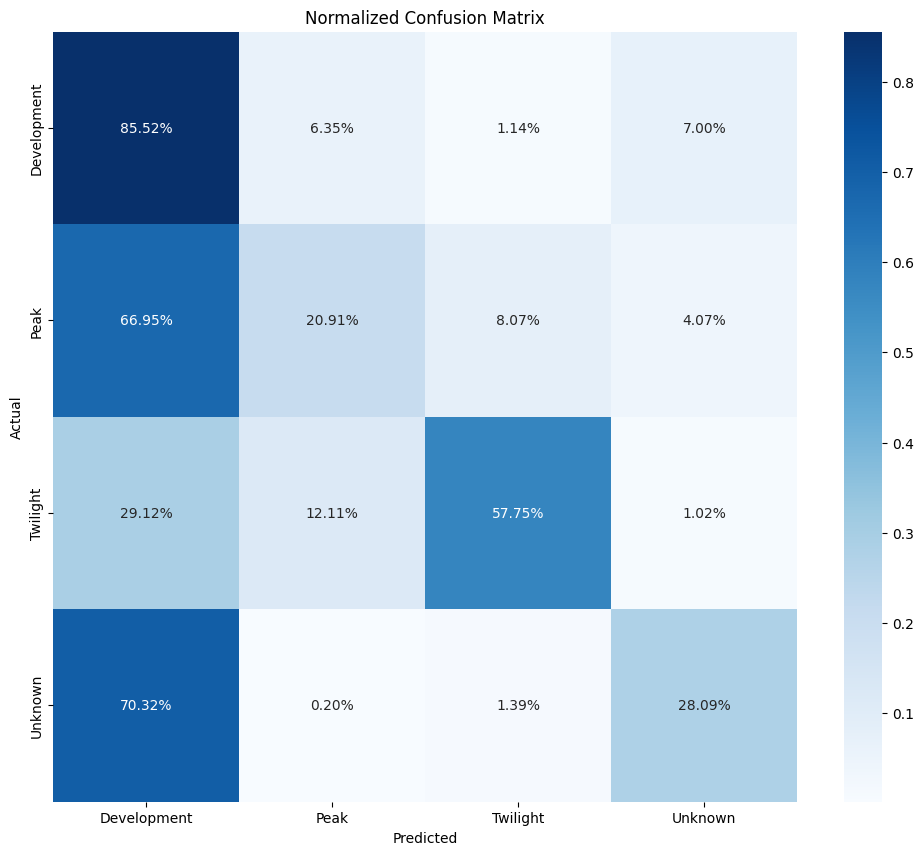


High Confidence Predictions (threshold=0.75):
              precision    recall  f1-score   support

 Development       0.56      0.68      0.61        28
        Peak       0.75      0.46      0.57        71
    Twilight       0.98      0.99      0.99      1364
     Unknown       0.61      0.69      0.65        16

    accuracy                           0.96      1479
   macro avg       0.72      0.71      0.70      1479
weighted avg       0.96      0.96      0.96      1479

Percentage of high confidence predictions: 22.81%

Confidence Distribution:
                 0
count  6484.000000
mean      0.618363
std       0.177442
min       0.307262
25%       0.508394
50%       0.542196
75%       0.719006
max       1.000000


In [17]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class FeatureEngineering:
    @staticmethod
    def safe_divide(a, b):
        return np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    
    def create_value_features(self, data, X):
        X['Value_Growth'] = data['Peak_Value'] - data['Current_Value']
        X['Value_Growth_Rate'] = self.safe_divide(X['Value_Growth'].values, (data['Current_Value'].values + 1))
        X['Value_Efficiency'] = self.safe_divide(data['Current_Value'].values, (data['Career_Games'].values + 1))
        X['Value_Peak_Ratio'] = self.safe_divide(data['Peak_Value'].values, (data['Current_Value'].values + 1))
        X['Value_per_Minute'] = self.safe_divide(data['Current_Value'].values, (data['Career_Minutes'].values + 1))
        return X
    
    def create_performance_features(self, data, X):
        X['Goals_per_Game'] = self.safe_divide(data['Career_Goals'].values, (data['Career_Games'].values + 1))
        X['Assists_per_Game'] = self.safe_divide(data['Career_Assists'].values, (data['Career_Games'].values + 1))
        X['Minutes_per_Game'] = self.safe_divide(data['Career_Minutes'].values, (data['Career_Games'].values + 1))
        X['Goal_Involvement'] = self.safe_divide((data['Career_Goals'].values + data['Career_Assists'].values), 
                                          (data['Career_Games'].values + 1))
        X['Goals_per_Minute'] = self.safe_divide(data['Career_Goals'].values, (data['Career_Minutes'].values + 1))
        return X
    
    def create_experience_features(self, data, X):
        X['Career_Games'] = data['Career_Games']
        X['Career_Minutes'] = data['Career_Minutes']
        X['Experience_Rate'] = self.safe_divide(data['Career_Minutes'].values, (data['Career_Games'].values + 1))
        X['Career_Intensity'] = self.safe_divide(data['Career_Minutes'].values, (data['Career_Games'].values + 1)) * np.log1p(data['Career_Games'])
        return X
    
    def create_team_features(self, data, X):
        X['Squad_Size'] = data['Squad_Size']
        X['Team_Average_Age'] = data['Team_Average_Age']
        X['Squad_Role'] = self.safe_divide(X['Minutes_per_Game'].values, data['Squad_Size'].values)
        return X
    
    def create_composite_features(self, X):
        X['Career_Progression'] = X['Value_Growth_Rate'] * np.log1p(X['Career_Games'])
        X['Performance_Intensity'] = X['Goal_Involvement'] * X['Minutes_per_Game']
        X['Value_Trajectory'] = X['Value_Growth_Rate'] * X['Performance_Intensity']
        X['Experience_Value_Ratio'] = X['Value_Efficiency'] * np.log1p(X['Career_Games'])
        return X
    
    def create_interaction_features(self, X):
        X['Age_Value_Interaction'] = X['Team_Average_Age'] * X['Value_Peak_Ratio']
        X['Squad_Value_Interaction'] = X['Squad_Size'] * X['Value_Growth_Rate']
        X['Team_Experience_Ratio'] = X['Career_Minutes'] / (X['Team_Average_Age'] * X['Squad_Size'])
        X['Value_Team_Context'] = X['Value_Growth_Rate'] * X['Squad_Role']
        X['Career_Team_Impact'] = X['Career_Progression'] * X['Squad_Role']
        X['Age_Experience_Interaction'] = X['Team_Average_Age'] * X['Team_Experience_Ratio']
        X['Value_Age_Squad_Interaction'] = X['Value_Growth_Rate'] * X['Team_Average_Age'] / X['Squad_Size']
        X['Career_Value_Experience'] = X['Career_Minutes'] * X['Value_Team_Context'] * X['Team_Experience_Ratio']
        return X
    
    def create_position_features(self, data, X):
        for pos in ['Defender', 'Goalkeeper', 'Midfield']:
            col = f'Position_{pos}'
            if col in data.columns:
                X[col] = data[col]
        
        X['Defensive_Impact'] = np.where(data['Position_Defender'] == 1,
                                       X['Minutes_per_Game'] * 1.5,
                                       X['Minutes_per_Game'])
        X['Attacking_Impact'] = X['Goals_per_Game'] * (1 - data['Position_Defender'])
        return X
    
    def process_features(self, X):
        # Clip extreme values
        for col in X.columns:
            if X[col].dtype in ['float64', 'float32']:
                X[col] = X[col].clip(-1e6, 1e6)
        
        # Replace infinities
        X = X.replace([np.inf, -np.inf], 0)
        return X
    
    def create_all_features(self, data):
        X = pd.DataFrame()
        X = self.create_value_features(data, X)
        X = self.create_performance_features(data, X)
        X = self.create_experience_features(data, X)
        X = self.create_team_features(data, X)
        X = self.create_composite_features(X)
        X = self.create_interaction_features(X)
        X = self.create_position_features(data, X)
        X = self.process_features(X)
        return X
    
    def prepare_data(data):
        feature_engineering = FeatureEngineering()
        X = feature_engineering.create_all_features(data)
    
        def get_career_phase(row):
            if row['Career_Phase_development']:
                return 0
            elif row['Career_Phase_peak']:
                return 1
            elif row['Career_Phase_twilight']:
                return 2
            return 3
    
        y = data.apply(get_career_phase, axis=1)
        return X, y

def main():
    # Load and prepare data
    data = pd.read_csv('D:/Projects/Machine Learning Applications for Soccer/cleaned_player_database.csv')
    X, y = FeatureEngineering.prepare_data(data)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Adjusted class weights to focus more on underperforming classes
    class_weights = {
        0: 3.0,  # Development
        1: 2.0,  # Peak
        2: 0.6,  # Twilight
        3: 3.0   # Unknown
    }
    
    # Create Random Forest model with optimized parameters
    model = RandomForestClassifier(
        n_estimators=750,
        max_depth=10,
        min_samples_leaf=3,
        min_samples_split=5,
        max_features='sqrt',
        bootstrap=True,
        class_weight=class_weights,
        random_state=42,
        n_jobs=-1,
        criterion='entropy',
        max_samples=0.85
    )
    
    # Train model with sample weights to further address class imbalance
    sample_weights = np.ones(len(y_train))
    for idx, y_val in enumerate(y_train):
        if y_val == 0:  # Development class
            sample_weights[idx] = 2.2
        elif y_val == 3:  # Unknown class
            sample_weights[idx] = 2.2
        elif y_val == 1:  # Peak class
            sample_weights[idx] = 1.5
    
    # Train model
    model.fit(X_train_scaled, y_train, sample_weight=sample_weights)
    
    # Cross-validation with stratification
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='balanced_accuracy')
    print("\nCross-validation scores (balanced accuracy):", cv_scores)
    print("Average CV score:", cv_scores.mean())
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                              target_names=['Development', 'Peak', 'Twilight', 'Unknown']))
    
    # Feature importance with confidence intervals
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importances,
        'std': std
    })
    
    print("\nTop 15 Most Important Features (with std deviation):")
    top_features = feature_importance.sort_values('importance', ascending=False).head(15)
    print(top_features)
    
    # Plot confusion matrix with percentages
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt='.2%',
        cmap='Blues',
        xticklabels=['Development', 'Peak', 'Twilight', 'Unknown'],
        yticklabels=['Development', 'Peak', 'Twilight', 'Unknown']
    )
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Get prediction probabilities with adjusted threshold
    probas = model.predict_proba(X_test_scaled)
    confidence = np.max(probas, axis=1)
    
    # High confidence predictions with adjusted threshold
    high_conf_mask = confidence >= 0.75
    print("\nHigh Confidence Predictions (threshold=0.75):")
    print(classification_report(
        y_test[high_conf_mask],
        y_pred[high_conf_mask],
        target_names=['Development', 'Peak', 'Twilight', 'Unknown']
    ))
    print(f"Percentage of high confidence predictions: {sum(high_conf_mask)/len(high_conf_mask)*100:.2f}%")
    
    # Print confidence distribution
    print("\nConfidence Distribution:")
    print(pd.DataFrame(confidence).describe())

if __name__ == "__main__":
    main()

#### Light Gradient Boosting Model


Cross-validation scores: [0.54867939 0.54212454 0.54154617 0.55881219 0.5474354 ]
Average CV score: 0.5477195391397596
Classification Report:
              precision    recall  f1-score   support

 Development       0.41      0.56      0.47      1229
        Peak       0.33      0.57      0.42      1425
    Twilight       0.94      0.57      0.71      3328
     Unknown       0.48      0.31      0.37       502

    accuracy                           0.55      6484
   macro avg       0.54      0.50      0.49      6484
weighted avg       0.67      0.55      0.58      6484


Top 15 Most Important Features:
                        feature  importance
3              Value_Peak_Ratio        1976
15             Team_Average_Age        1562
27  Value_Age_Squad_Interaction        1516
21        Age_Value_Interaction        1453
23        Team_Experience_Ratio        1318
4              Value_per_Minute        1311
1             Value_Growth_Rate        1291
28      Career_Value_Experience      

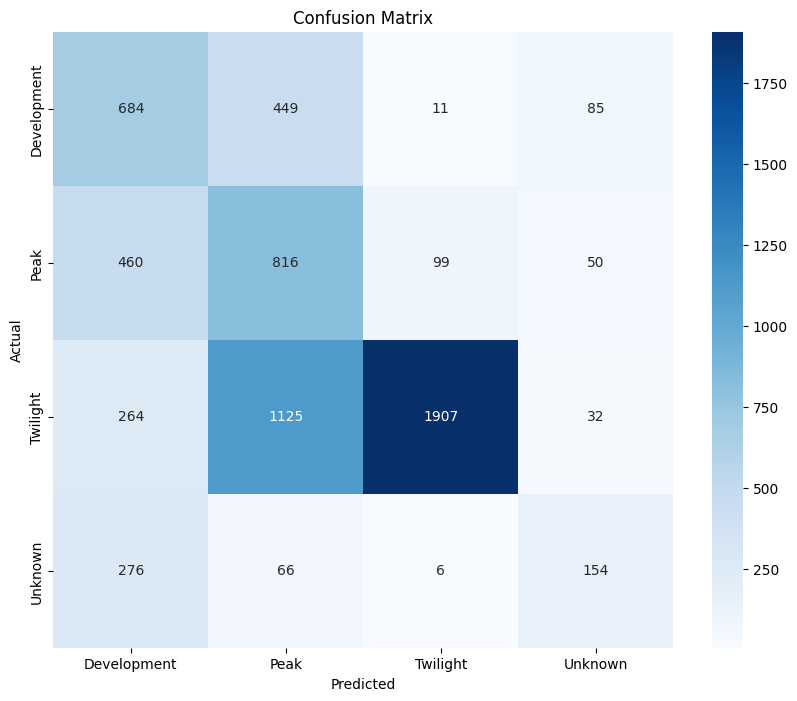


High Confidence Predictions (threshold=0.8):
              precision    recall  f1-score   support

 Development       0.62      0.42      0.50        24
        Peak       0.58      0.75      0.66       102
    Twilight       0.98      0.97      0.98      1356
     Unknown       0.89      0.73      0.80        11

    accuracy                           0.94      1493
   macro avg       0.77      0.72      0.73      1493
weighted avg       0.95      0.94      0.94      1493

Percentage of high confidence predictions: 23.03%


In [13]:
# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Enhanced feature engineering
def create_features(data):
    X = pd.DataFrame()
    
    # Helper function to safely divide
    def safe_divide(a, b):
        return np.divide(a, b, out=np.zeros_like(a), where=b!=0)
    
    # Value Features (enhanced)
    X['Value_Growth'] = data['Peak_Value'] - data['Current_Value']
    X['Value_Growth_Rate'] = safe_divide(X['Value_Growth'].values, (data['Current_Value'].values + 1))
    X['Value_Efficiency'] = safe_divide(data['Current_Value'].values, (data['Career_Games'].values + 1))
    X['Value_Peak_Ratio'] = safe_divide(data['Peak_Value'].values, (data['Current_Value'].values + 1))
    X['Value_per_Minute'] = safe_divide(data['Current_Value'].values, (data['Career_Minutes'].values + 1))
    
    # Performance Metrics (enhanced)
    X['Goals_per_Game'] = safe_divide(data['Career_Goals'].values, (data['Career_Games'].values + 1))
    X['Assists_per_Game'] = safe_divide(data['Career_Assists'].values, (data['Career_Games'].values + 1))
    X['Minutes_per_Game'] = safe_divide(data['Career_Minutes'].values, (data['Career_Games'].values + 1))
    X['Goal_Involvement'] = safe_divide((data['Career_Goals'].values + data['Career_Assists'].values), 
                                      (data['Career_Games'].values + 1))
    X['Goals_per_Minute'] = safe_divide(data['Career_Goals'].values, (data['Career_Minutes'].values + 1))
    
    # Experience Features (enhanced)
    X['Career_Games'] = data['Career_Games']
    X['Career_Minutes'] = data['Career_Minutes']
    X['Experience_Rate'] = safe_divide(data['Career_Minutes'].values, (data['Career_Games'].values + 1))
    X['Career_Intensity'] = safe_divide(data['Career_Minutes'].values, (data['Career_Games'].values + 1)) * np.log1p(data['Career_Games'])
    
    # Team Context
    X['Squad_Size'] = data['Squad_Size']
    X['Team_Average_Age'] = data['Team_Average_Age']
    X['Squad_Role'] = safe_divide(X['Minutes_per_Game'].values, data['Squad_Size'].values)
    
    # Advanced Composite Features
    X['Career_Progression'] = X['Value_Growth_Rate'] * np.log1p(X['Career_Games'])
    X['Performance_Intensity'] = X['Goal_Involvement'] * X['Minutes_per_Game']
    X['Value_Trajectory'] = X['Value_Growth_Rate'] * X['Performance_Intensity']
    X['Experience_Value_Ratio'] = X['Value_Efficiency'] * np.log1p(X['Career_Games'])

    # Enhanced Team Context Features
    X['Squad_Size'] = data['Squad_Size']
    X['Team_Average_Age'] = data['Team_Average_Age']
    X['Squad_Role'] = safe_divide(X['Minutes_per_Game'].values, data['Squad_Size'].values)
    
    # New Feature Interactions (based on importance)
    X['Age_Value_Interaction'] = X['Team_Average_Age'] * X['Value_Peak_Ratio']
    X['Squad_Value_Interaction'] = X['Squad_Size'] * X['Value_Growth_Rate']
    X['Team_Experience_Ratio'] = X['Career_Minutes'] / (X['Team_Average_Age'] * X['Squad_Size'])
    X['Value_Team_Context'] = X['Value_Growth_Rate'] * X['Squad_Role']
    X['Career_Team_Impact'] = X['Career_Progression'] * X['Squad_Role']

     # New interaction features based on top important features
    X['Age_Experience_Interaction'] = X['Team_Average_Age'] * X['Team_Experience_Ratio']
    X['Value_Age_Squad_Interaction'] = X['Value_Growth_Rate'] * X['Team_Average_Age'] / X['Squad_Size']
    X['Career_Value_Experience'] = X['Career_Minutes'] * X['Value_Team_Context'] * X['Team_Experience_Ratio']
    
    
    # Position Features
    for pos in ['Defender', 'Goalkeeper', 'Midfield']:
        col = f'Position_{pos}'
        if col in data.columns:
            X[col] = data[col]
            
    # Position-specific performance
    X['Defensive_Impact'] = np.where(data['Position_Defender'] == 1,
                                   X['Minutes_per_Game'] * 1.5,
                                   X['Minutes_per_Game'])
    X['Attacking_Impact'] = X['Goals_per_Game'] * (1 - data['Position_Defender'])
    
    # Clip extreme values
    for col in X.columns:
        if X[col].dtype in ['float64', 'float32']:
            X[col] = X[col].clip(-1e6, 1e6)
    
    # Replace any remaining infinities
    X = X.replace([np.inf, -np.inf], 0)
    
    return X

# Prepare data
def prepare_data(data):
    X = create_features(data)
    
    def get_career_phase(row):
        if row['Career_Phase_development']:
            return 0
        elif row['Career_Phase_peak']:
            return 1
        elif row['Career_Phase_twilight']:
            return 2
        return 3
    
    y = data.apply(get_career_phase, axis=1)
    return X, y

# Main execution
def main():
    # Prepare data
    X, y = prepare_data(data)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    class_weights = {
    0: 2.5,  # Development (increased)
    1: 2.5,  # Peak (increased)
    2: 0.4,  # Twilight (reduced)
    3: 2.0   # Unknown
}

    # Create LightGBM model with optimized parameters
    # Update the LightGBM parameters
    # Updated parameters
    # Fine-tune the parameters
    params = {
    'n_estimators': 250,          # Balanced number
    'learning_rate': 0.04,        # Slightly increased
    'max_depth': 6,               # Back to more conservative
    'num_leaves': 35,             # Balanced
    'min_child_samples': 40,      # Back to previous better value
    'colsample_bytree': 0.87,     # Slightly increased
    'subsample': 0.87,            # Slightly increased
    'reg_alpha': 0.12,            # Balanced regularization
    'reg_lambda': 0.12,           # Balanced regularization
    'random_state': 42,
    'n_jobs': -1,
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'verbose': -1,
    'class_weight': {
        0: 2.5,  # Development (balanced)
        1: 2.5,  # Peak (balanced)
        2: 0.4,  # Twilight
        3: 2.3   # Unknown (slightly increased)
    }
}
    
    model = lgb.LGBMClassifier(**params)
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    print("\nCross-validation scores:", cv_scores)
    print("Average CV score:", cv_scores.mean())
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred,
                              target_names=['Development', 'Peak', 'Twilight', 'Unknown']))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    })
    print("\nTop 15 Most Important Features:")
    print(feature_importance.sort_values('importance', ascending=False).head(15))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Development', 'Peak', 'Twilight', 'Unknown'],
        yticklabels=['Development', 'Peak', 'Twilight', 'Unknown']
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Get prediction probabilities
    probas = model.predict_proba(X_test_scaled)
    confidence = np.max(probas, axis=1)
    
    # High confidence predictions
    high_conf_mask = confidence >= 0.8
    print("\nHigh Confidence Predictions (threshold=0.8):")
    print(classification_report(
        y_test[high_conf_mask],
        y_pred[high_conf_mask],
        target_names=['Development', 'Peak', 'Twilight', 'Unknown']
    ))
    print(f"Percentage of high confidence predictions: {sum(high_conf_mask)/len(high_conf_mask)*100:.2f}%")

if __name__ == "__main__":
    main()